##테이터살펴보기

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/petfinder-mini.csv')
df.head(10)

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2
5,Cat,3,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,This is a stray kitten that came to my house. ...,2,2
6,Cat,12,Domestic Long Hair,Male,Black,No Color,Medium,Long,No,Not Sure,Healthy,300,anyone within the area of ipoh or taiping who ...,3,1
7,Cat,2,Domestic Medium Hair,Female,Gray,No Color,Medium,Medium,No,No,Healthy,0,"healthy and active, feisty kitten found in nei...",6,1
8,Cat,12,Domestic Medium Hair,Female,Black,White,Medium,Medium,Not Sure,Not Sure,Healthy,0,"Very manja and gentle stray cat found, we woul...",2,4
9,Dog,2,Mixed Breed,Male,Black,Brown,Medium,Short,No,No,Healthy,0,"For serious adopter, please do sms or call for...",7,1


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11537 entries, 0 to 11536
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Type           11537 non-null  object
 1   Age            11537 non-null  int64 
 2   Breed1         11537 non-null  object
 3   Gender         11537 non-null  object
 4   Color1         11537 non-null  object
 5   Color2         11537 non-null  object
 6   MaturitySize   11537 non-null  object
 7   FurLength      11537 non-null  object
 8   Vaccinated     11537 non-null  object
 9   Sterilized     11537 non-null  object
 10  Health         11537 non-null  object
 11  Fee            11537 non-null  int64 
 12  Description    11528 non-null  object
 13  PhotoAmt       11537 non-null  int64 
 14  AdoptionSpeed  11537 non-null  int64 
dtypes: int64(4), object(11)
memory usage: 1.3+ MB


In [3]:
df.select_dtypes(include=np.number).columns.tolist()

['Age', 'Fee', 'PhotoAmt', 'AdoptionSpeed']

In [4]:
for col in df.columns.tolist():
  print(f"{col}:{df[col].astype('category').cat.codes.nunique()}")

Type:2
Age:105
Breed1:166
Gender:2
Color1:7
Color2:7
MaturitySize:3
FurLength:3
Vaccinated:3
Sterilized:3
Health:3
Fee:65
Description:10692
PhotoAmt:31
AdoptionSpeed:5


In [5]:
from datetime import datetime
from math import exp
from collections import defaultdict

import numpy as np
from numpy.random import default_rng, SeedSequence
import pandas as pd
from pandas.api.types import CategoricalDtype

from scipy import stats
from scipy.special import expit, logit
from scipy.stats.mstats import winsorize
from scipy.interpolate import interp1d, make_interp_spline, BSpline

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
mpl.style.use('tableau-colorblind10')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from IPython.display import HTML, Image, display, Markdown as md

import patsy
from patsy import dmatrices
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

array([[<Axes: title={'center': 'Age'}>]], dtype=object)

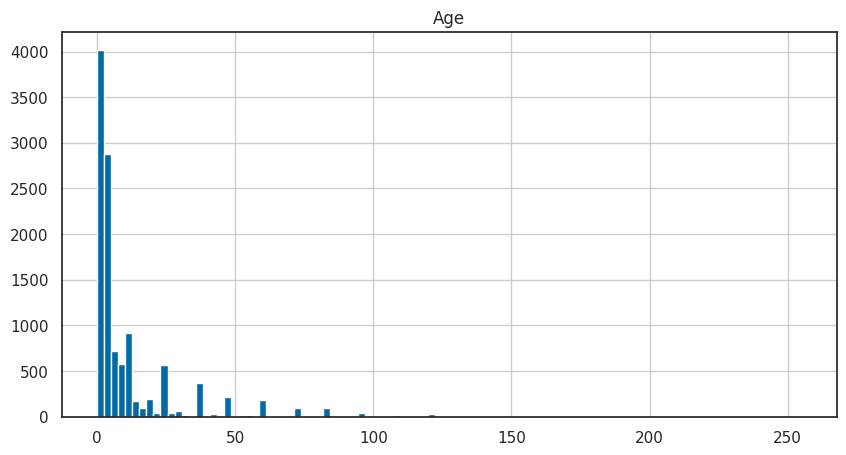

In [6]:
df[['Age']].hist(figsize=(10,5), bins=100)

array([[<Axes: title={'center': 'Age'}>, <Axes: title={'center': 'Fee'}>],
       [<Axes: title={'center': 'PhotoAmt'}>,
        <Axes: title={'center': 'AdoptionSpeed'}>]], dtype=object)

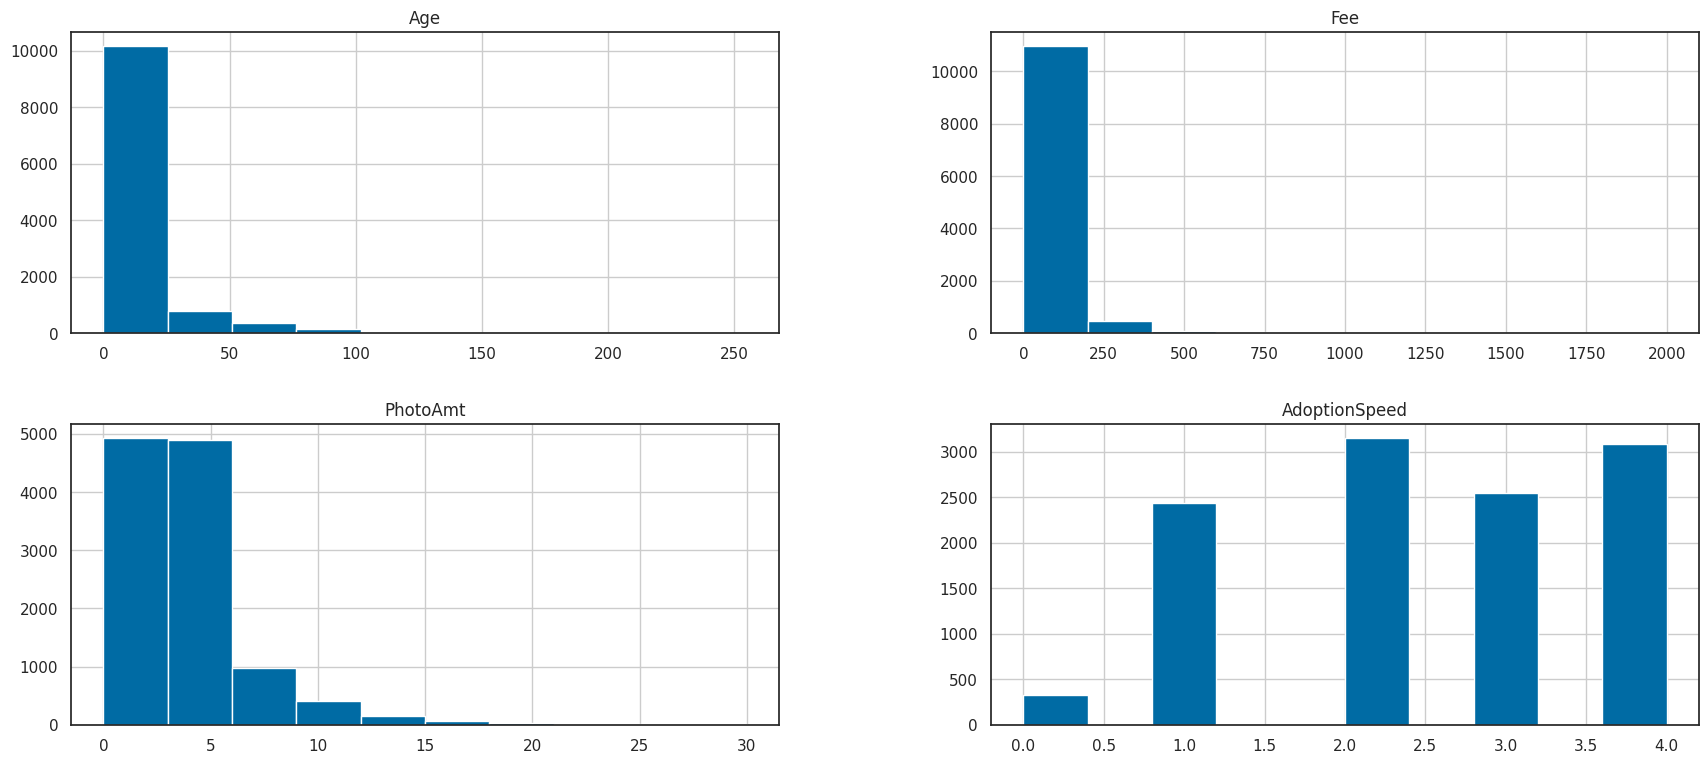

In [7]:
df.hist(figsize=(21,9))

In [8]:
df.describe()

,Age,Fee,PhotoAmt,AdoptionSpeed
count,11537.000000,11537.000000,11537.000000,11537.000000
mean,11.743434,23.957268,3.610211,2.486522
std,19.324221,80.024226,3.145872,1.173275
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,2.000000,2.000000
50%,4.000000,0.000000,3.000000,2.000000
75%,12.000000,0.000000,5.000000,4.000000
max,255.000000,2000.000000,30.000000,4.000000


In [9]:
df.isna().sum()

Type             0
Age              0
Breed1           0
Gender           0
Color1           0
Color2           0
MaturitySize     0
FurLength        0
Vaccinated       0
Sterilized       0
Health           0
Fee              0
Description      9
PhotoAmt         0
AdoptionSpeed    0
dtype: int64

In [10]:
# In the original dataset, 'AdoptionSpeed' of 4 indicates a pet was not adopted.
df['Adopted'] = np.where(df['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
petfinder = df.drop(columns=['AdoptionSpeed', 'Description'])
petfinder

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Adopted
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,0,0
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1,1
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,1,1
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,3,0


In [11]:
features = petfinder.copy()
labels = features.pop('Adopted')

features.columns.tolist()

['Type',
 'Age',
 'Breed1',
 'Gender',
 'Color1',
 'Color2',
 'MaturitySize',
 'FurLength',
 'Vaccinated',
 'Sterilized',
 'Health',
 'Fee',
 'PhotoAmt']

#FEATURE ENGINEERING

In [12]:
features['Is_Cat'] = np.where(features['Type']=='Dog', 0., 1.)
features

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Is_Cat
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1.0
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1.0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,0.0
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,0.0
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,0,0.0
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1,1.0
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,1,0.0
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,3,1.0


In [13]:
features['Is_Female'] = np.where(features['Gender']=='Male', 0., 1.)
features

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Is_Cat,Is_Female
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1.0,0.0
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1.0,0.0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,0.0,0.0
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,0.0,1.0
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,0,0.0,0.0
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1,1.0,1.0
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,1,0.0,1.0
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,3,1.0,1.0


In [14]:
features['Vaccinated'].value_counts()

Yes         5060
No          4962
Not Sure    1515
Name: Vaccinated, dtype: int64

In [15]:
pd.get_dummies(features['Vaccinated'], prefix='Vaccinated')

,Vaccinated_No,Vaccinated_Not Sure,Vaccinated_Yes
0,1,0,0
1,0,1,0
2,0,0,1
3,0,0,1
4,1,0,0
...,...,...,...
11532,0,1,0
11533,1,0,0
11534,0,0,1
11535,0,0,1


In [16]:
features = features.join(pd.get_dummies(features['Vaccinated'], prefix='Vaccinated'))
features

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,Is_Cat,Is_Female,Vaccinated_No,Vaccinated_Not Sure,Vaccinated_Yes
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1.0,0.0,1,0,0
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1.0,0.0,0,1,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,0.0,0.0,0,0,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,0.0,1.0,0,0,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,0.0,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,0,0.0,0.0,0,1,0
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1,1.0,1.0,1,0,0
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,1,0.0,1.0,0,0,1
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,3,1.0,1.0,0,0,1


In [17]:
features['Sterilized'].value_counts()

No          7497
Yes         2697
Not Sure    1343
Name: Sterilized, dtype: int64

In [18]:
features = features.join(pd.get_dummies(features['Sterilized'], prefix='Sterilized'))
features

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,...,Fee,PhotoAmt,Is_Cat,Is_Female,Vaccinated_No,Vaccinated_Not Sure,Vaccinated_Yes,Sterilized_No,Sterilized_Not Sure,Sterilized_Yes
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,...,100,1,1.0,0.0,1,0,0,1,0,0
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,...,0,2,1.0,0.0,0,1,0,0,1,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,...,0,7,0.0,0.0,0,0,1,1,0,0
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,...,150,8,0.0,1.0,0,0,1,1,0,0
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,...,0,3,0.0,0.0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,...,0,0,0.0,0.0,0,1,0,1,0,0
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,...,0,1,1.0,1.0,1,0,0,1,0,0
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,...,0,1,0.0,1.0,0,0,1,1,0,0
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,...,0,3,1.0,1.0,0,0,1,0,0,1


In [19]:
features['Health'].value_counts()

Healthy           11098
Minor Injury        409
Serious Injury       30
Name: Health, dtype: int64

In [20]:
features = features.join(pd.get_dummies(features['Health'], prefix='Health'))
features

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,...,Is_Female,Vaccinated_No,Vaccinated_Not Sure,Vaccinated_Yes,Sterilized_No,Sterilized_Not Sure,Sterilized_Yes,Health_Healthy,Health_Minor Injury,Health_Serious Injury
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,...,0.0,1,0,0,1,0,0,1,0,0
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,...,0.0,0,1,0,0,1,0,1,0,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,...,0.0,0,0,1,1,0,0,1,0,0
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,...,1.0,0,0,1,1,0,0,1,0,0
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,...,0.0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,...,0.0,0,1,0,1,0,0,1,0,0
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,...,1.0,1,0,0,1,0,0,1,0,0
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,...,1.0,0,0,1,1,0,0,1,0,0
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,...,1.0,0,0,1,0,0,1,1,0,0


In [21]:
features['MaturitySize'].unique()

array(['Small', 'Medium', 'Large'], dtype=object)

In [22]:
maturity_size_type = CategoricalDtype(categories=['Small', 'Medium', 'Large'], ordered=True)

In [23]:
features['MaturitySize'] = features['MaturitySize'].astype(maturity_size_type)

In [24]:
features = features.join(pd.get_dummies(features['MaturitySize'], prefix='MaturitySize'))
features

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,...,Vaccinated_Yes,Sterilized_No,Sterilized_Not Sure,Sterilized_Yes,Health_Healthy,Health_Minor Injury,Health_Serious Injury,MaturitySize_Small,MaturitySize_Medium,MaturitySize_Large
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,...,0,1,0,0,1,0,0,1,0,0
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,...,0,0,1,0,1,0,0,0,1,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,...,1,1,0,0,1,0,0,0,1,0
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,...,1,1,0,0,1,0,0,0,1,0
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,...,0,1,0,0,1,0,0,0,1,0
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,...,0,1,0,0,1,0,0,0,1,0
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,...,1,1,0,0,1,0,0,1,0,0
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,...,1,0,0,1,1,0,0,1,0,0


In [25]:
fur_length_type = CategoricalDtype(categories=['Short', 'Medium', 'Long'], ordered=True)

In [26]:
features['FurLength'] = features['FurLength'].astype(fur_length_type)

In [27]:
features = features.join(pd.get_dummies(features['FurLength'], prefix='FurLength'))
features

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,...,Sterilized_Yes,Health_Healthy,Health_Minor Injury,Health_Serious Injury,MaturitySize_Small,MaturitySize_Medium,MaturitySize_Large,FurLength_Short,FurLength_Medium,FurLength_Long
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,...,0,1,0,0,1,0,0,1,0,0
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,...,0,1,0,0,0,1,0,0,1,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,...,0,1,0,0,0,1,0,0,1,0
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,...,0,1,0,0,0,1,0,1,0,0
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,...,0,1,0,0,0,1,0,0,1,0
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,...,0,1,0,0,0,1,0,1,0,0
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,...,0,1,0,0,1,0,0,0,0,1
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,...,1,1,0,0,1,0,0,1,0,0


In [28]:
features['Color1'].unique()

array(['Black', 'Brown', 'Cream', 'Gray', 'Golden', 'White', 'Yellow'],
      dtype=object)

In [29]:
features = features.join(pd.get_dummies(features['Color1'], prefix='Color1'))
features

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,...,FurLength_Short,FurLength_Medium,FurLength_Long,Color1_Black,Color1_Brown,Color1_Cream,Color1_Golden,Color1_Gray,Color1_White,Color1_Yellow
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,...,1,0,0,1,0,0,0,0,0,0
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,...,0,1,0,1,0,0,0,0,0,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,...,0,1,0,0,1,0,0,0,0,0
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,...,1,0,0,1,0,0,0,0,0,0
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,...,0,1,0,0,1,0,0,0,0,0
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,...,1,0,0,0,0,1,0,0,0,0
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,...,0,0,1,1,0,0,0,0,0,0
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,...,1,0,0,0,0,0,0,0,0,1


In [30]:
features['Color2'].unique()

array(['White', 'Brown', 'No Color', 'Gray', 'Cream', 'Golden', 'Yellow'],
      dtype=object)

In [31]:
features = features.join(pd.get_dummies(features['Color2'], prefix='Color2'))
features

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,...,Color1_Gray,Color1_White,Color1_Yellow,Color2_Brown,Color2_Cream,Color2_Golden,Color2_Gray,Color2_No Color,Color2_White,Color2_Yellow
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,...,0,0,0,0,0,0,0,0,1,0
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,...,0,0,0,1,0,0,0,0,0,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,...,0,0,0,0,0,0,0,0,1,0
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,...,0,0,0,1,0,0,0,0,0,0
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,...,0,0,0,0,0,1,0,0,0,0
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,...,0,0,0,0,0,0,1,0,0,0
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,...,0,0,0,0,0,0,0,0,1,0
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,...,0,0,1,0,0,0,0,0,1,0


In [32]:
len(sorted(features['Age'].unique()))

105

In [33]:
ptile_labels = ['ptile1', 'ptile2', 'ptile3', 'ptile4', 'ptile5']
features = features.join(pd.get_dummies(pd.qcut(features['Age'], q=[0, .2, .4, .6, .8, 1], labels=ptile_labels), prefix='Age'))
features

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,...,Color2_Golden,Color2_Gray,Color2_No Color,Color2_White,Color2_Yellow,Age_ptile1,Age_ptile2,Age_ptile3,Age_ptile4,Age_ptile5
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,...,0,0,0,1,0,0,1,0,0,0
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,...,0,0,0,0,0,1,0,0,0,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,...,0,0,0,1,0,1,0,0,0,0
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,...,0,0,0,0,0,0,0,1,0,0
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,...,1,0,0,0,0,0,0,0,0,1
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,...,0,1,0,0,0,1,0,0,0,0
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,...,0,0,0,1,0,0,0,1,0,0
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,...,0,0,0,1,0,0,0,0,1,0


In [34]:
features['Breed1'].value_counts()[:20]

Mixed Breed             4629
Domestic Short Hair     2605
Domestic Medium Hair     865
Tabby                    242
Domestic Long Hair       223
Siamese                  202
Shih Tzu                 178
Persian                  177
Labrador Retriever       175
Poodle                   161
Terrier                  143
Golden Retriever         133
German Shepherd Dog       90
Beagle                    86
Rottweiler                77
Spitz                     77
Calico                    69
Schnauzer                 66
American Shorthair        66
Jack Russell Terrier      61
Name: Breed1, dtype: int64

In [35]:
keep_breeds = ['Mixed Breed', 'Domestic Short Hair', 'Domestic Medium Hair', 'Tabby',
               'Domestic Long Hair', 'Siamese', 'Shih Tzu', 'Labrador Retriever',
               'Persian', 'Poodle', 'Poodle', 'Terrier', 'Golden Retriever']

dd = defaultdict(lambda: 'Other')

for _, breed in enumerate(keep_breeds):
    dd[breed] = breed

In [36]:
features = features.join(pd.get_dummies(features['Breed1'].map(dd), prefix='Breed1'))
features

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,...,Breed1_Golden Retriever,Breed1_Labrador Retriever,Breed1_Mixed Breed,Breed1_Other,Breed1_Persian,Breed1_Poodle,Breed1_Shih Tzu,Breed1_Siamese,Breed1_Tabby,Breed1_Terrier
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,...,0,0,0,0,0,0,0,0,1,0
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,...,0,0,0,0,0,0,0,0,0,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,...,0,0,1,0,0,0,0,0,0,0
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,...,0,0,1,0,0,0,0,0,0,0
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,...,0,0,0,0,0,1,0,0,0,0
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,...,0,0,0,0,0,0,0,0,0,0
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,...,0,0,0,1,0,0,0,0,0,0
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,...,0,0,0,0,0,0,0,0,0,0


In [37]:
categorical_predictors = ['Type', 'Gender', 'Age', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

#Data Readiness Check


##data processing


In [38]:
len(list(features.columns))

62

In [39]:
predictors = [
  #'Type',
  #'Age',
  #'Breed1',
  #'Gender',
  #'Color1',
  #'Color2',
  #'MaturitySize',
  #'FurLength',
  #'Vaccinated',
  #'Sterilized',
  #'Health',
  #'Fee',
  'PhotoAmt',
  'Is_Cat',
  'Is_Female',
  #'Vaccinated_No',
  'Vaccinated_Not Sure',
  'Vaccinated_Yes',
  #'Sterilized_No',
  'Sterilized_Not Sure',
  'Sterilized_Yes',
  'Health_Healthy',
  'Health_Minor Injury',
  'Health_Serious Injury',
  'MaturitySize_Small',
  'MaturitySize_Medium',
  'MaturitySize_Large',
  'FurLength_Short',
  'FurLength_Medium',
  'FurLength_Long',
  #'Color1_Black',
  'Color1_Brown',
  'Color1_Cream',
  'Color1_Golden',
  'Color1_Gray',
  'Color1_White',
  'Color1_Yellow',
  'Color2_Brown',
  'Color2_Cream',
  'Color2_Golden',
  'Color2_Gray',
  #'Color2_No Color',
  'Color2_White',
  'Color2_Yellow',
  'Age_ptile1',
  'Age_ptile2',
  'Age_ptile3',
  'Age_ptile4',
  #'Age_ptile5',
  'Breed1_Domestic Long Hair',
  'Breed1_Domestic Medium Hair',
  'Breed1_Domestic Short Hair',
  'Breed1_Golden Retriever',
  'Breed1_Labrador Retriever',
  'Breed1_Mixed Breed',
  #'Breed1_Other',
  'Breed1_Persian',
  'Breed1_Poodle',
  'Breed1_Shih Tzu',
  'Breed1_Siamese',
  'Breed1_Tabby',
  'Breed1_Terrier'
]

features = features[predictors].copy()
# Standardized Mean Difference
features[predictors] = (features[predictors] - features[predictors].mean()) / features[predictors].std()
features

,PhotoAmt,Is_Cat,Is_Female,Vaccinated_Not Sure,Vaccinated_Yes,Sterilized_Not Sure,Sterilized_Yes,Health_Healthy,Health_Minor Injury,Health_Serious Injury,...,Breed1_Domestic Short Hair,Breed1_Golden Retriever,Breed1_Labrador Retriever,Breed1_Mixed Breed,Breed1_Persian,Breed1_Poodle,Breed1_Shih Tzu,Breed1_Siamese,Breed1_Tabby,Breed1_Terrier
0,-0.829726,1.156374,-1.129152,-0.388786,-0.883832,-0.362950,-0.552326,0.19888,-0.191705,-0.051058,...,-0.540021,-0.107989,-0.1241,-0.818556,-0.124818,-0.11896,-0.125176,-0.133489,6.831508,-0.112024
1,-0.511849,1.156374,-1.129152,2.571888,-0.883832,2.754961,-0.552326,0.19888,-0.191705,-0.051058,...,-0.540021,-0.107989,-0.1241,-0.818556,-0.124818,-0.11896,-0.125176,-0.133489,-0.146368,-0.112024
2,1.077536,-0.864697,-1.129152,-0.388786,1.131339,-0.362950,-0.552326,0.19888,-0.191705,-0.051058,...,-0.540021,-0.107989,-0.1241,1.221557,-0.124818,-0.11896,-0.125176,-0.133489,-0.146368,-0.112024
3,1.395413,-0.864697,0.885544,-0.388786,1.131339,-0.362950,-0.552326,0.19888,-0.191705,-0.051058,...,-0.540021,-0.107989,-0.1241,1.221557,-0.124818,-0.11896,-0.125176,-0.133489,-0.146368,-0.112024
4,-0.193972,-0.864697,-1.129152,-0.388786,-0.883832,-0.362950,-0.552326,0.19888,-0.191705,-0.051058,...,-0.540021,-0.107989,-0.1241,1.221557,-0.124818,-0.11896,-0.125176,-0.133489,-0.146368,-0.112024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,-1.147603,-0.864697,-1.129152,2.571888,-0.883832,-0.362950,-0.552326,0.19888,-0.191705,-0.051058,...,-0.540021,-0.107989,-0.1241,-0.818556,-0.124818,8.40549,-0.125176,-0.133489,-0.146368,-0.112024
11533,-0.829726,1.156374,0.885544,-0.388786,-0.883832,-0.362950,-0.552326,0.19888,-0.191705,-0.051058,...,1.851619,-0.107989,-0.1241,-0.818556,-0.124818,-0.11896,-0.125176,-0.133489,-0.146368,-0.112024
11534,-0.829726,-0.864697,0.885544,-0.388786,1.131339,-0.362950,-0.552326,0.19888,-0.191705,-0.051058,...,-0.540021,-0.107989,-0.1241,-0.818556,-0.124818,-0.11896,-0.125176,-0.133489,-0.146368,-0.112024
11535,-0.193972,1.156374,0.885544,-0.388786,1.131339,-0.362950,1.810368,0.19888,-0.191705,-0.051058,...,1.851619,-0.107989,-0.1241,-0.818556,-0.124818,-0.11896,-0.125176,-0.133489,-0.146368,-0.112024


In [40]:
features.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
PhotoAmt,11537.0,0.0,1.0,-1.15,-0.51,-0.19,0.44,8.39
Is_Cat,11537.0,0.0,1.0,-0.86,-0.86,-0.86,1.16,1.16
Is_Female,11537.0,-0.0,1.0,-1.13,-1.13,0.89,0.89,0.89
Vaccinated_Not Sure,11537.0,0.0,1.0,-0.39,-0.39,-0.39,-0.39,2.57
Vaccinated_Yes,11537.0,-0.0,1.0,-0.88,-0.88,-0.88,1.13,1.13
Sterilized_Not Sure,11537.0,0.0,1.0,-0.36,-0.36,-0.36,-0.36,2.75
Sterilized_Yes,11537.0,0.0,1.0,-0.55,-0.55,-0.55,-0.55,1.81
Health_Healthy,11537.0,-0.0,1.0,-5.03,0.20,0.20,0.20,0.20
Health_Minor Injury,11537.0,-0.0,1.0,-0.19,-0.19,-0.19,-0.19,5.22
Health_Serious Injury,11537.0,-0.0,1.0,-0.05,-0.05,-0.05,-0.05,19.58


array([[<Axes: title={'center': 'PhotoAmt'}>,
        <Axes: title={'center': 'Is_Cat'}>,
        <Axes: title={'center': 'Is_Female'}>,
        <Axes: title={'center': 'Vaccinated_Not Sure'}>,
        <Axes: title={'center': 'Vaccinated_Yes'}>,
        <Axes: title={'center': 'Sterilized_Not Sure'}>,
        <Axes: title={'center': 'Sterilized_Yes'}>],
       [<Axes: title={'center': 'Health_Healthy'}>,
        <Axes: title={'center': 'Health_Minor Injury'}>,
        <Axes: title={'center': 'Health_Serious Injury'}>,
        <Axes: title={'center': 'MaturitySize_Small'}>,
        <Axes: title={'center': 'MaturitySize_Medium'}>,
        <Axes: title={'center': 'MaturitySize_Large'}>,
        <Axes: title={'center': 'FurLength_Short'}>],
       [<Axes: title={'center': 'FurLength_Medium'}>,
        <Axes: title={'center': 'FurLength_Long'}>,
        <Axes: title={'center': 'Color1_Brown'}>,
        <Axes: title={'center': 'Color1_Cream'}>,
        <Axes: title={'center': 'Color1_Golden'

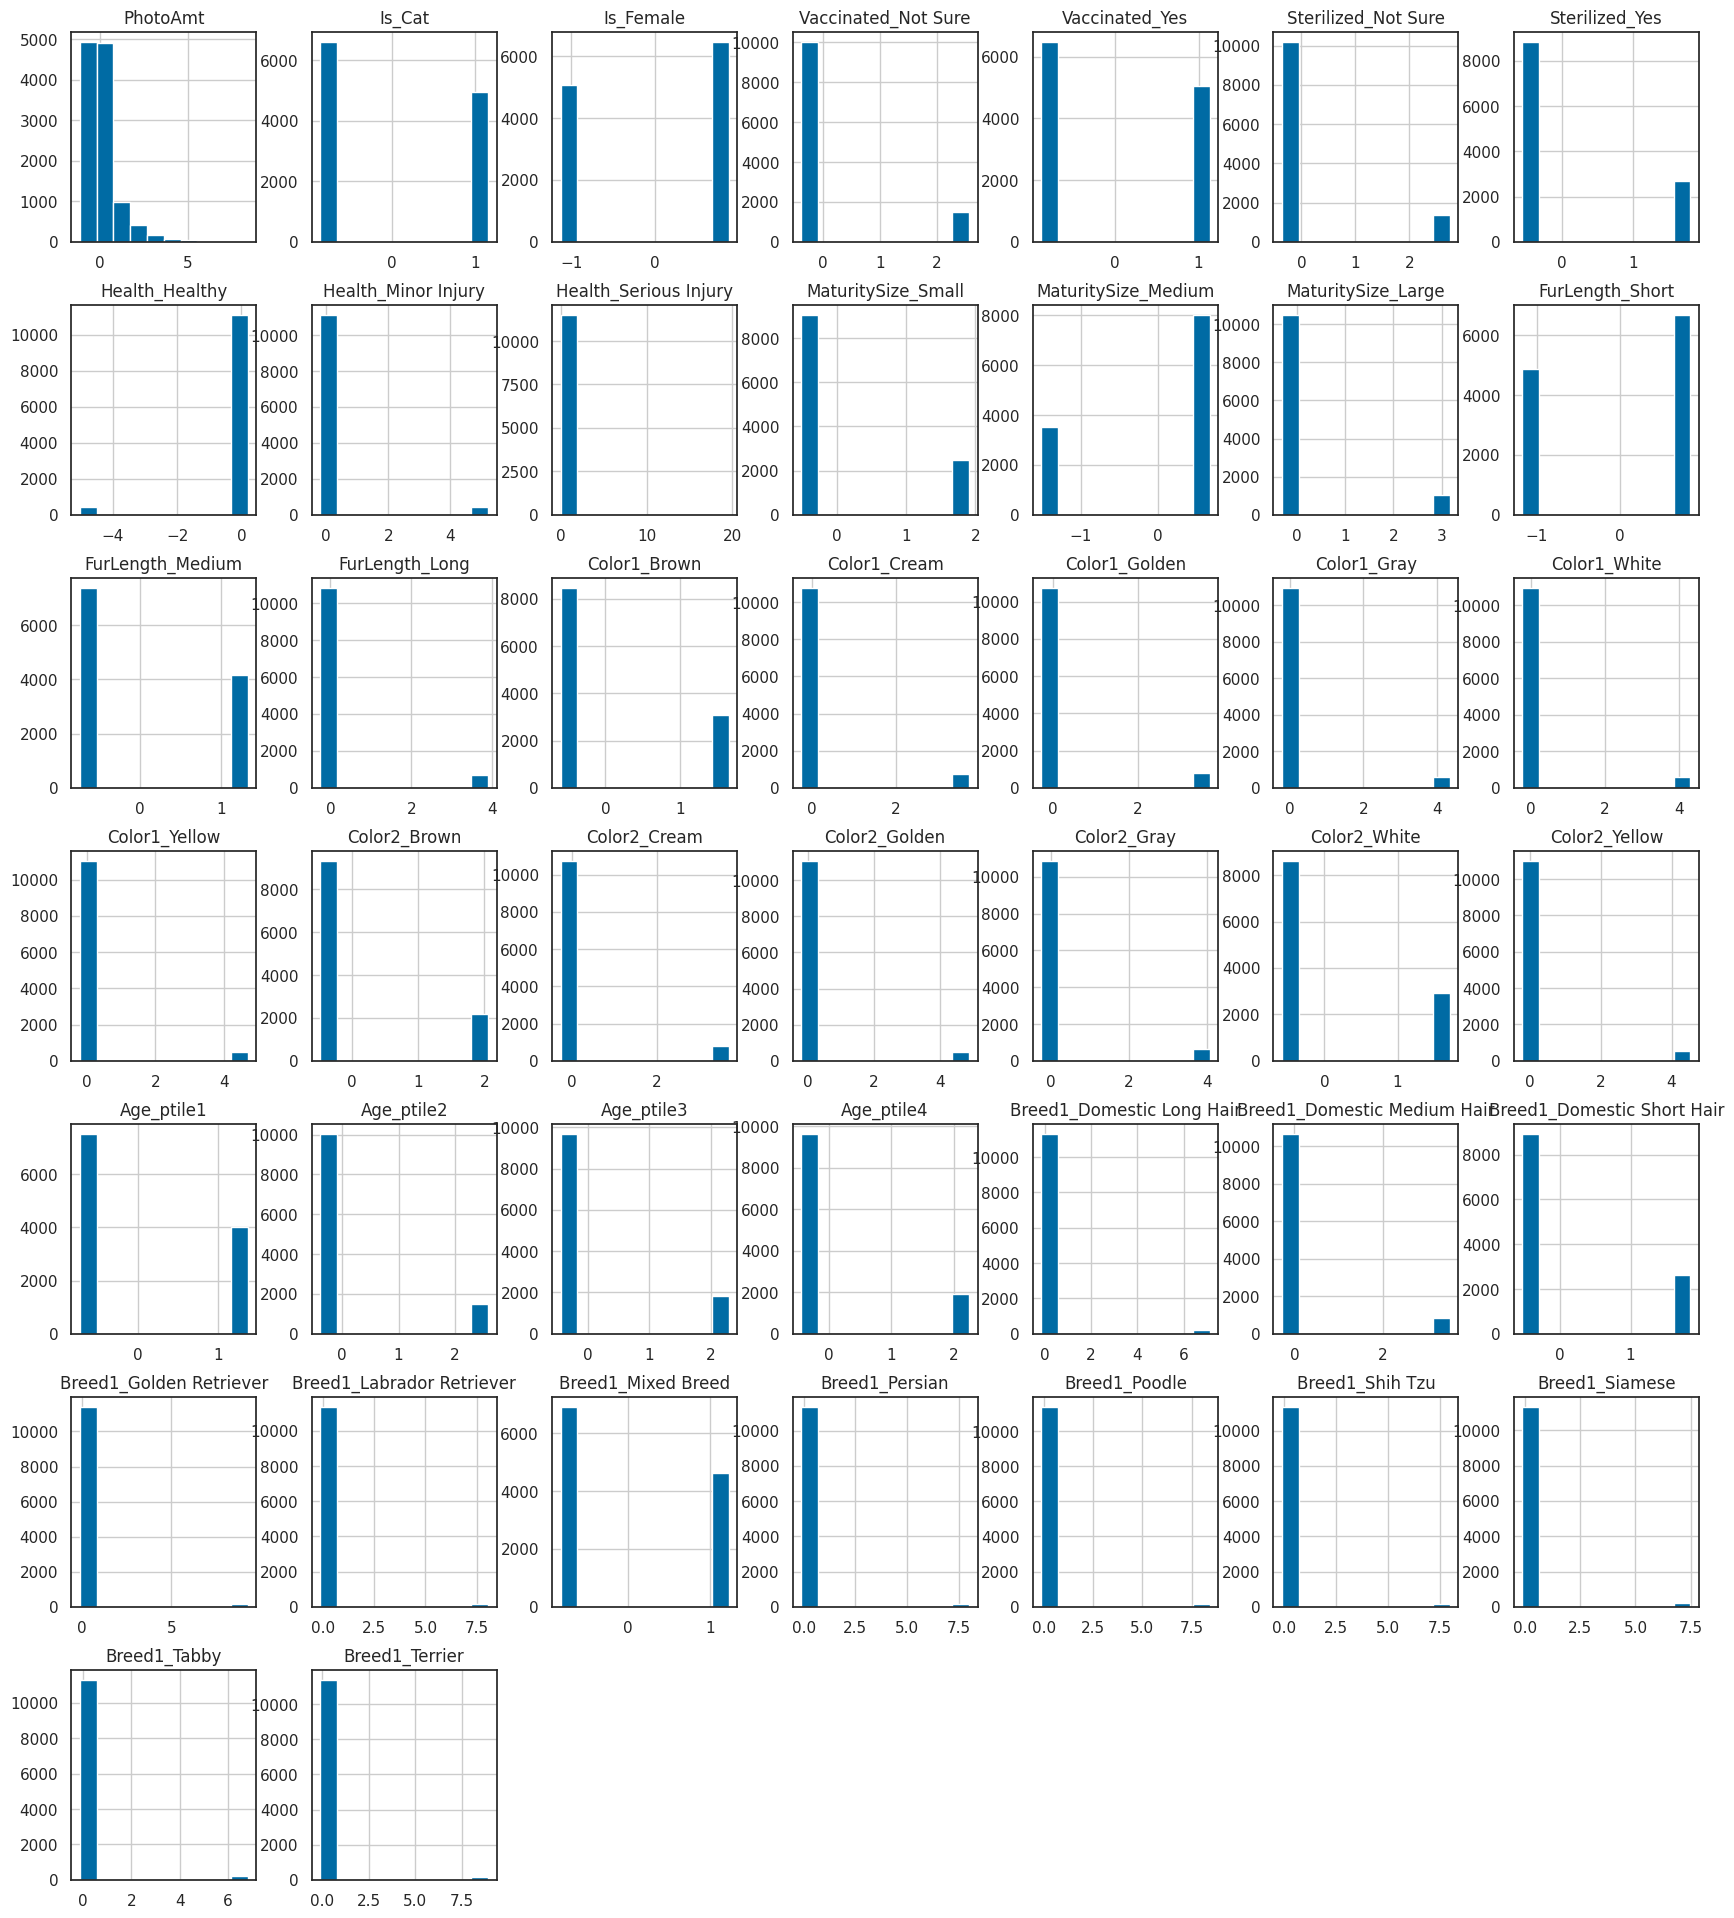

In [ ]:
features.hist(figsize=(21,24))

In [ ]:
features

,PhotoAmt,Is_Cat,Is_Female,Vaccinated_Not Sure,Vaccinated_Yes,Sterilized_Not Sure,Sterilized_Yes,Health_Healthy,Health_Minor Injury,Health_Serious Injury,...,Breed1_Domestic Short Hair,Breed1_Golden Retriever,Breed1_Labrador Retriever,Breed1_Mixed Breed,Breed1_Persian,Breed1_Poodle,Breed1_Shih Tzu,Breed1_Siamese,Breed1_Tabby,Breed1_Terrier
0,-0.829726,1.156374,-1.129152,-0.388786,-0.883832,-0.362950,-0.552326,0.19888,-0.191705,-0.051058,...,-0.540021,-0.107989,-0.1241,-0.818556,-0.124818,-0.11896,-0.125176,-0.133489,6.831508,-0.112024
1,-0.511849,1.156374,-1.129152,2.571888,-0.883832,2.754961,-0.552326,0.19888,-0.191705,-0.051058,...,-0.540021,-0.107989,-0.1241,-0.818556,-0.124818,-0.11896,-0.125176,-0.133489,-0.146368,-0.112024
2,1.077536,-0.864697,-1.129152,-0.388786,1.131339,-0.362950,-0.552326,0.19888,-0.191705,-0.051058,...,-0.540021,-0.107989,-0.1241,1.221557,-0.124818,-0.11896,-0.125176,-0.133489,-0.146368,-0.112024
3,1.395413,-0.864697,0.885544,-0.388786,1.131339,-0.362950,-0.552326,0.19888,-0.191705,-0.051058,...,-0.540021,-0.107989,-0.1241,1.221557,-0.124818,-0.11896,-0.125176,-0.133489,-0.146368,-0.112024
4,-0.193972,-0.864697,-1.129152,-0.388786,-0.883832,-0.362950,-0.552326,0.19888,-0.191705,-0.051058,...,-0.540021,-0.107989,-0.1241,1.221557,-0.124818,-0.11896,-0.125176,-0.133489,-0.146368,-0.112024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,-1.147603,-0.864697,-1.129152,2.571888,-0.883832,-0.362950,-0.552326,0.19888,-0.191705,-0.051058,...,-0.540021,-0.107989,-0.1241,-0.818556,-0.124818,8.40549,-0.125176,-0.133489,-0.146368,-0.112024
11533,-0.829726,1.156374,0.885544,-0.388786,-0.883832,-0.362950,-0.552326,0.19888,-0.191705,-0.051058,...,1.851619,-0.107989,-0.1241,-0.818556,-0.124818,-0.11896,-0.125176,-0.133489,-0.146368,-0.112024
11534,-0.829726,-0.864697,0.885544,-0.388786,1.131339,-0.362950,-0.552326,0.19888,-0.191705,-0.051058,...,-0.540021,-0.107989,-0.1241,-0.818556,-0.124818,-0.11896,-0.125176,-0.133489,-0.146368,-0.112024
11535,-0.193972,1.156374,0.885544,-0.388786,1.131339,-0.362950,1.810368,0.19888,-0.191705,-0.051058,...,1.851619,-0.107989,-0.1241,-0.818556,-0.124818,-0.11896,-0.125176,-0.133489,-0.146368,-0.112024


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1234)

In [ ]:
y_train

2155     1
9164     0
2944     1
4779     0
11335    1
        ..
11468    0
7221     0
1318     1
8915     1
11055    1
Name: Adopted, Length: 9229, dtype: int64

In [ ]:
X_train.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
PhotoAmt,9229.0,-0.00,0.99,-1.15,-0.51,-0.19,0.44,8.39
Is_Cat,9229.0,-0.01,1.00,-0.86,-0.86,-0.86,1.16,1.16
Is_Female,9229.0,0.01,1.00,-1.13,-1.13,0.89,0.89,0.89
Vaccinated_Not Sure,9229.0,-0.00,1.00,-0.39,-0.39,-0.39,-0.39,2.57
Vaccinated_Yes,9229.0,0.00,1.00,-0.88,-0.88,-0.88,1.13,1.13
Sterilized_Not Sure,9229.0,-0.00,1.00,-0.36,-0.36,-0.36,-0.36,2.75
Sterilized_Yes,9229.0,0.01,1.01,-0.55,-0.55,-0.55,-0.55,1.81
Health_Healthy,9229.0,-0.00,1.00,-5.03,0.20,0.20,0.20,0.20
Health_Minor Injury,9229.0,0.00,1.01,-0.19,-0.19,-0.19,-0.19,5.22
Health_Serious Injury,9229.0,-0.00,0.96,-0.05,-0.05,-0.05,-0.05,19.58


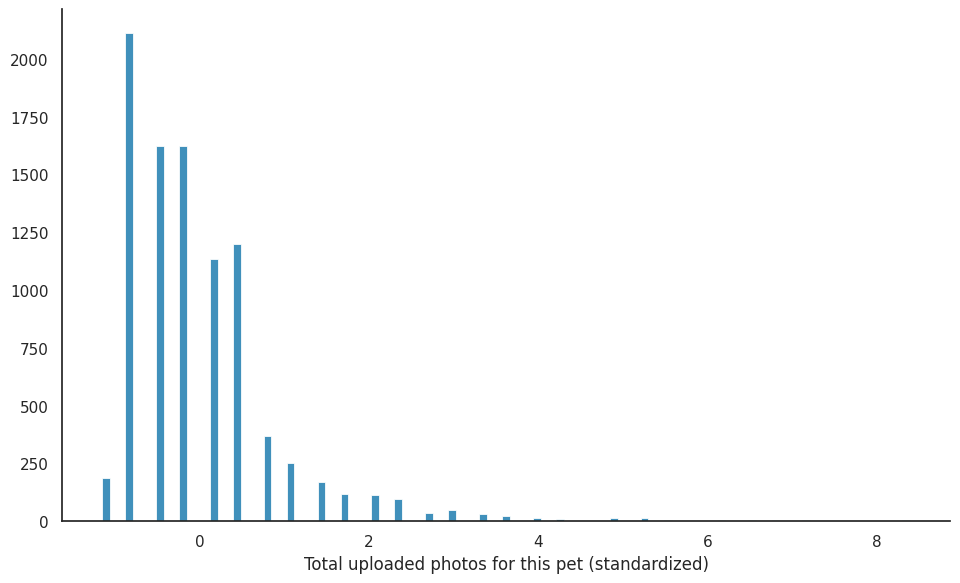

In [ ]:
g = sns.displot(X_train['PhotoAmt'], height=6, aspect=10/6)
g.set_axis_labels('Total uploaded photos for this pet (standardized)', '')
g.set_titles('')

#모델링


##statsmodels

###랜덤포레스트


### 로지스틱 회귀 모델


In [ ]:
import statsmodels.api as sm

# 종속 변수와 독립 변수 설정
y = y_train.values
X = X_train['PhotoAmt'].values
X = sm.add_constant(X)

# 로지스틱 회귀 모델 생성
logit_model = sm.Logit(y, X)

# 모델 피팅
result = logit_model.fit()

# 모델 요약 정보 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.574621
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 9229
Model:                          Logit   Df Residuals:                     9227
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Dec 2023   Pseudo R-squ.:                0.009491
Time:                        20:45:39   Log-Likelihood:                -5303.2
converged:                       True   LL-Null:                       -5354.0
Covariance Type:            nonrobust   LLR p-value:                 6.709e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0290      0.024     42.974      0.000       0.982       1.076
x1             0.2760      0.

In [ ]:
y = y_train.values

X = X_train['PhotoAmt'].values
X = sm.add_constant(X)

X.shape, y.shape

((9229, 2), (9229,))

In [ ]:
y[:5]

array([1, 0, 1, 0, 1])

In [ ]:
X[:5]

array([[ 1.        , -0.51184881],
       [ 1.        , -0.82972574],
       [ 1.        , -0.51184881],
       [ 1.        , -0.82972574],
       [ 1.        , -0.19397188]])

In [ ]:
# Describe model
m1_sm = sm.Logit(y, X)

# Fit model
res_sm = m1_sm.fit()

# Summarize model
print(res_sm.summary())

Optimization terminated successfully.
         Current function value: 0.574621
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 9229
Model:                          Logit   Df Residuals:                     9227
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Dec 2023   Pseudo R-squ.:                0.009491
Time:                        20:45:39   Log-Likelihood:                -5303.2
converged:                       True   LL-Null:                       -5354.0
Covariance Type:            nonrobust   LLR p-value:                 6.709e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0290      0.024     42.974      0.000       0.982       1.076
x1             0.2760      0.

In [ ]:
print("Parameters: ", [np.round(val, 2) for val in res_sm.params])
print("Standard errors: ", [np.round(val, 2) for val in res_sm.bse])
print("Predicted values: ", [np.round(val, 2) for val in res_sm.predict()[:10]])

Parameters:  [1.03, 0.28]
Standard errors:  [0.02, 0.03]
Predicted values:  [0.71, 0.69, 0.71, 0.69, 0.73, 0.86, 0.69, 0.73, 0.67, 0.71]


In [ ]:
pd.concat([pd.Series(res_sm.predict(X)), pd.Series(expit(res_sm.fittedvalues))], axis=1).rename({0: 'Predicted', 1: 'Inverse Logit(Fitted)'}, axis=1)

,Predicted,Inverse Logit(Fitted)
0,0.708424,0.708424
1,0.689980,0.689980
2,0.708424,0.708424
3,0.689980,0.689980
4,0.726207,0.726207
...,...,...
9224,0.670910,0.670910
9225,0.708424,0.708424
9226,0.830546,0.830546
9227,0.726207,0.726207


In [ ]:
res_sm_margeff = res_sm.get_margeff()
print(res_sm_margeff.summary())

        Logit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0534      0.006      9.444      0.000       0.042       0.065


In [ ]:
# Thus, adding 1 to PhotoAmt -- that is, uploading an additional photo of the pet -- corresponds to a positive difference in the probability of adoption of about 6%.

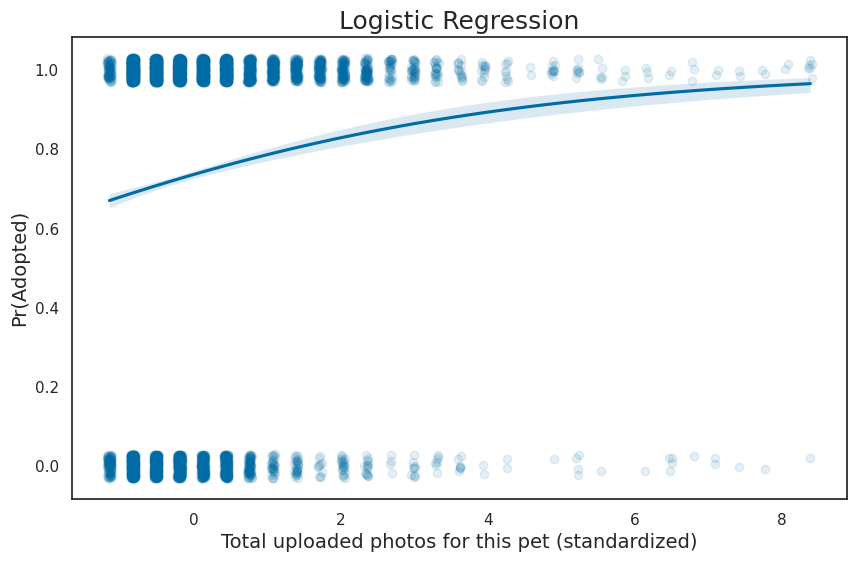

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x='PhotoAmt', y='Adopted', data=X_train.join(pd.Series(labels, name='Adopted')),
            logistic=True, n_boot=500, x_jitter=.03, y_jitter=.03,
            scatter_kws={'alpha': 0.10}, # Set transparency to 10%
            ax=ax)
ax.set_ylabel('Pr(Adopted)', fontsize=14)
ax.set_xlabel('Total uploaded photos for this pet (standardized)', fontsize=14)
ax.set_title('Logistic Regression', fontsize=18);

In [ ]:
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

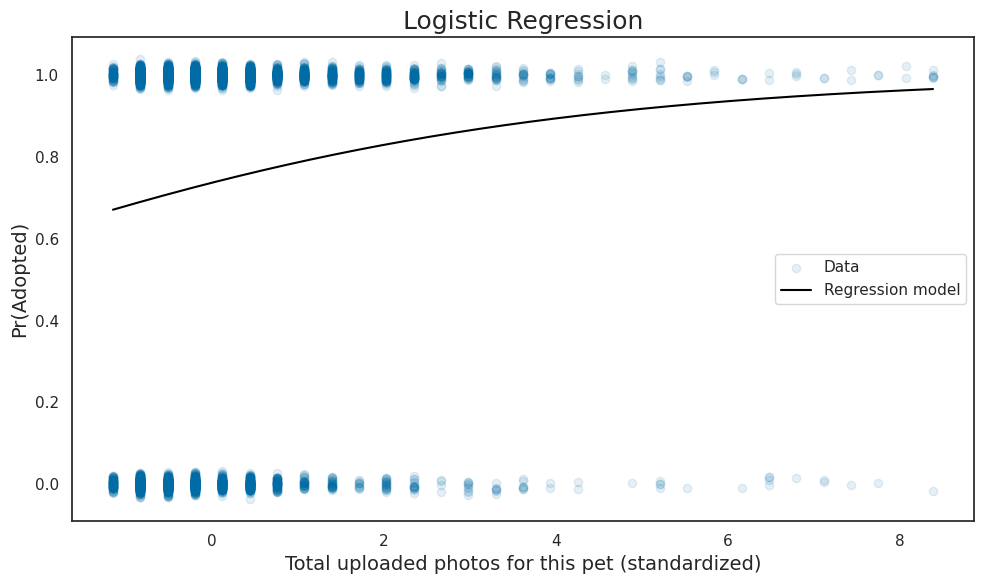

In [ ]:
x = np.linspace(X_train['PhotoAmt'].min(), X_train['PhotoAmt'].max(), 1000)
y = res_sm.predict(pd.DataFrame({'const': 1, 'PhotoAmt': x}))
f = interp1d(x, y, kind = "cubic")
xnew = np.linspace(X_train['PhotoAmt'].min(), X_train['PhotoAmt'].max(), 1000)
ynew = f(xnew)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(X_train['PhotoAmt'], rand_jitter(y_train), alpha=0.1, label='Data')
plt.plot(xnew, ynew, linestyle='-', color='black', label='Regression model')

ax.set_ylabel('Pr(Adopted)', fontsize=14)
ax.set_xlabel('Total uploaded photos for this pet (standardized)', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout();

In [ ]:
X_tests = X_test['PhotoAmt'].values
X_tests = sm.add_constant(X_tests)

X_tests[:10]

array([[ 1.        , -0.51184881],
       [ 1.        , -0.19397188],
       [ 1.        ,  3.30267434],
       [ 1.        , -0.19397188],
       [ 1.        , -1.14760267],
       [ 1.        ,  0.44178198],
       [ 1.        , -0.82972574],
       [ 1.        ,  3.30267434],
       [ 1.        ,  0.44178198],
       [ 1.        ,  0.75965891]])

In [ ]:
y_pred_probs = res_sm.predict(exog=X_tests)

y_pred_probs[:10]

array([0.70842438, 0.72620723, 0.87439424, 0.72620723, 0.67091008,
       0.75967595, 0.68997962, 0.87439424, 0.75967595, 0.77532436])

In [ ]:
y_preds = list(map(round, y_pred_probs))

y_preds[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

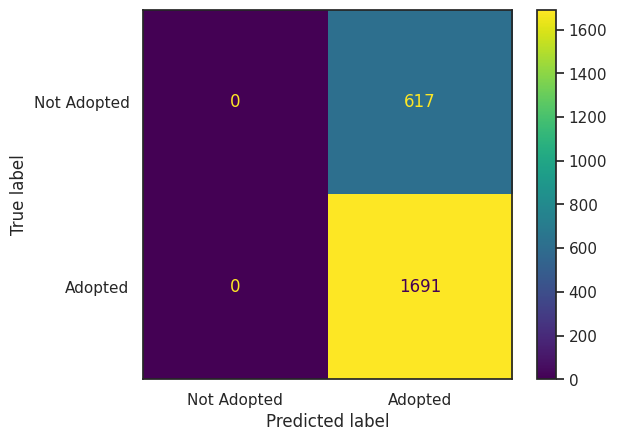

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Adopted','Adopted'])
disp.plot()

In [ ]:
print(classification_report(y_test, y_preds, target_names=['Not Adopted', 'Adopted']))

              precision    recall  f1-score   support

 Not Adopted       0.00      0.00      0.00       617
     Adopted       0.73      1.00      0.85      1691

    accuracy                           0.73      2308
   macro avg       0.37      0.50      0.42      2308
weighted avg       0.54      0.73      0.62      2308



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test_accuracy_sm = accuracy_score(y_test, y_preds)
print('Test set (aka out-of-sample) Accuracy: {:.3f}'.format(test_accuracy_sm))

Test set (aka out-of-sample) Accuracy: 0.733


In [ ]:
test_precision_sm = precision_score(y_test, y_preds)
print('Test set (aka out-of-sample) Precision: {:.3f}'.format(test_precision_sm))

Test set (aka out-of-sample) Precision: 0.733


In [ ]:
test_recall_sm = recall_score(y_test, y_preds)
print('Test set (aka out-of-sample) Recall: {:.3f}'.format(test_recall_sm))

Test set (aka out-of-sample) Recall: 1.000


##scikit-learn

In [ ]:
y = y_train.values

X = X_train['PhotoAmt'].values
X = sm.add_constant(X)

X.shape, y.shape

((9229, 2), (9229,))

In [ ]:
lr = LogisticRegression(penalty='none', fit_intercept=False)

res_sk = lr.fit(X, y)

res_sk

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(fit_intercept=False, penalty='none')

In [ ]:
coefs = [np.round(val, 4) for val in res_sk.coef_.flatten()]

ols_coefs = pd.DataFrame.from_dict( dict(zip(['Intercept', 'PhotoAmt'], coefs)), orient='index')
ols_coefs.columns = ['coef']

ols_coefs

,coef
Intercept,1.029
PhotoAmt,0.276


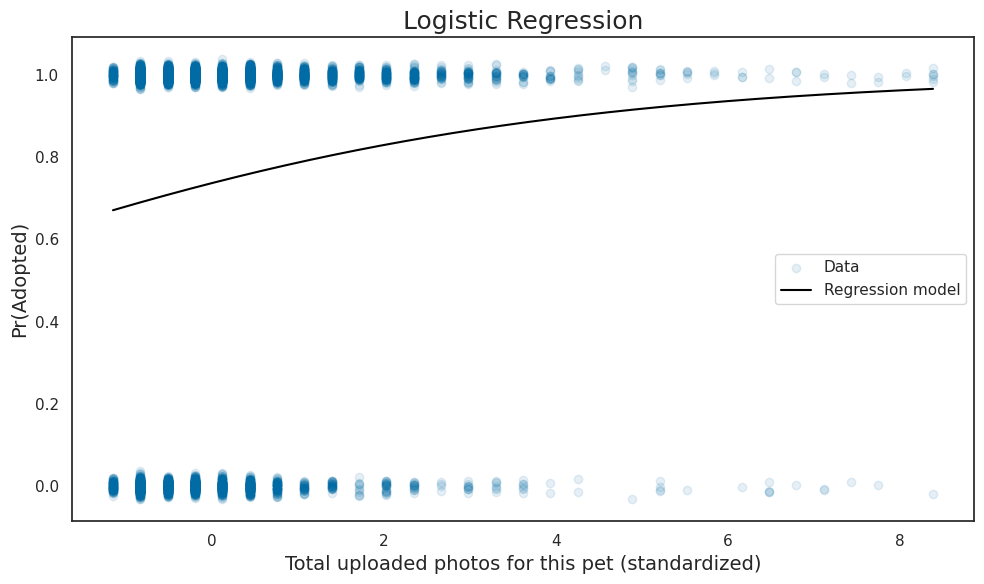

In [ ]:
x = np.linspace(X_train['PhotoAmt'].min(), X_train['PhotoAmt'].max(), 1000)
y = res_sm.predict(pd.DataFrame({'const': 1, 'PhotoAmt': x}))
f = interp1d(x, y, kind = "cubic")
xnew = np.linspace(X_train['PhotoAmt'].min(), X_train['PhotoAmt'].max(), 1000)
ynew = f(xnew)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(X_train['PhotoAmt'], rand_jitter(y_train), alpha=0.1, label='Data')
plt.plot(xnew, ynew, linestyle='-', color='black', label='Regression model')

ax.set_ylabel('Pr(Adopted)', fontsize=14)
ax.set_xlabel('Total uploaded photos for this pet (standardized)', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout();

In [ ]:
X_tests = X_test['PhotoAmt'].values
X_tests = sm.add_constant(X_tests)

X_tests[:10]

array([[ 1.        , -0.51184881],
       [ 1.        , -0.19397188],
       [ 1.        ,  3.30267434],
       [ 1.        , -0.19397188],
       [ 1.        , -1.14760267],
       [ 1.        ,  0.44178198],
       [ 1.        , -0.82972574],
       [ 1.        ,  3.30267434],
       [ 1.        ,  0.44178198],
       [ 1.        ,  0.75965891]])

In [ ]:
res_sk.classes_

array([0, 1])

In [ ]:
# The returned estimates for all classes are ordered by the label of classes: res_sk.classes_

y_pred_probs = res_sk.predict_proba(X_tests)

y_pred_probs[:10]

array([[0.29157635, 0.70842365],
       [0.27379342, 0.72620658],
       [0.12560575, 0.87439425],
       [0.27379342, 0.72620658],
       [0.32909084, 0.67090916],
       [0.24032452, 0.75967548],
       [0.3100212 , 0.6899788 ],
       [0.12560575, 0.87439425],
       [0.24032452, 0.75967548],
       [0.22467604, 0.77532396]])

In [ ]:
y_preds = res_sk.predict(X_tests)

y_preds[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

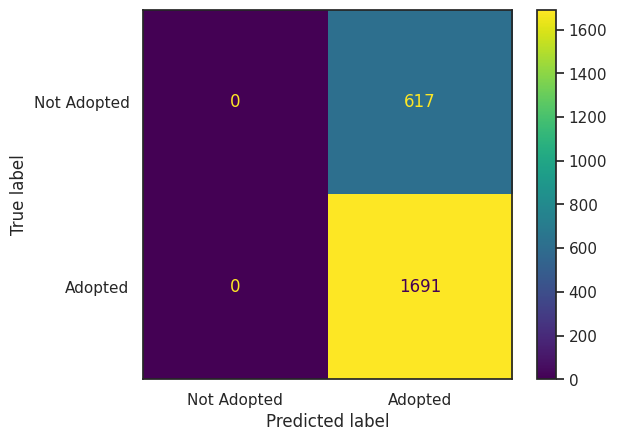

In [ ]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Adopted','Adopted'])
disp.plot()

In [ ]:
print(classification_report(y_test, y_preds, target_names=['Not Adopted', 'Adopted']))

              precision    recall  f1-score   support

 Not Adopted       0.00      0.00      0.00       617
     Adopted       0.73      1.00      0.85      1691

    accuracy                           0.73      2308
   macro avg       0.37      0.50      0.42      2308
weighted avg       0.54      0.73      0.62      2308



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test_accuracy_sk = accuracy_score(y_test, y_preds)
print('Test set (aka out-of-sample) Accuracy: {:.3f}'.format(test_accuracy_sk))

Test set (aka out-of-sample) Accuracy: 0.733


In [ ]:
test_precision_sk = precision_score(y_test, y_preds)
print('Test set (aka out-of-sample) Precision: {:.3f}'.format(test_precision_sk))

Test set (aka out-of-sample) Precision: 0.733


In [ ]:
test_recall_sk = recall_score(y_test, y_preds)
print('Test set (aka out-of-sample) Recall: {:.3f}'.format(test_recall_sk))

Test set (aka out-of-sample) Recall: 1.000


##tensorflow

In [ ]:
dataframe = pd.read_csv('/content/petfinder-mini.csv')
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [ ]:
# In the original dataset, `'AdoptionSpeed'` of `4` indicates
# a pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

In [ ]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [ ]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

9229 training examples
1154 validation examples
1154 test examples


In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('target')
    df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
      ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [ ]:
def get_normalization_layer(name, dataset):
    normalizer = layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)

    return normalizer

In [ ]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    return lambda feature: encoder(index(feature))

In [ ]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

<ipython-input-84-fbec27310d8d>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
<ipython-input-84-fbec27310d8d>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
<ipython-input-84-fbec27310d8d>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [ ]:
all_inputs = []
encoded_features = []

for header in ['PhotoAmt', 'Fee']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [ ]:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [ ]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header,
                                                dataset=train_ds,
                                                dtype='string',
                                                max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

In [ ]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

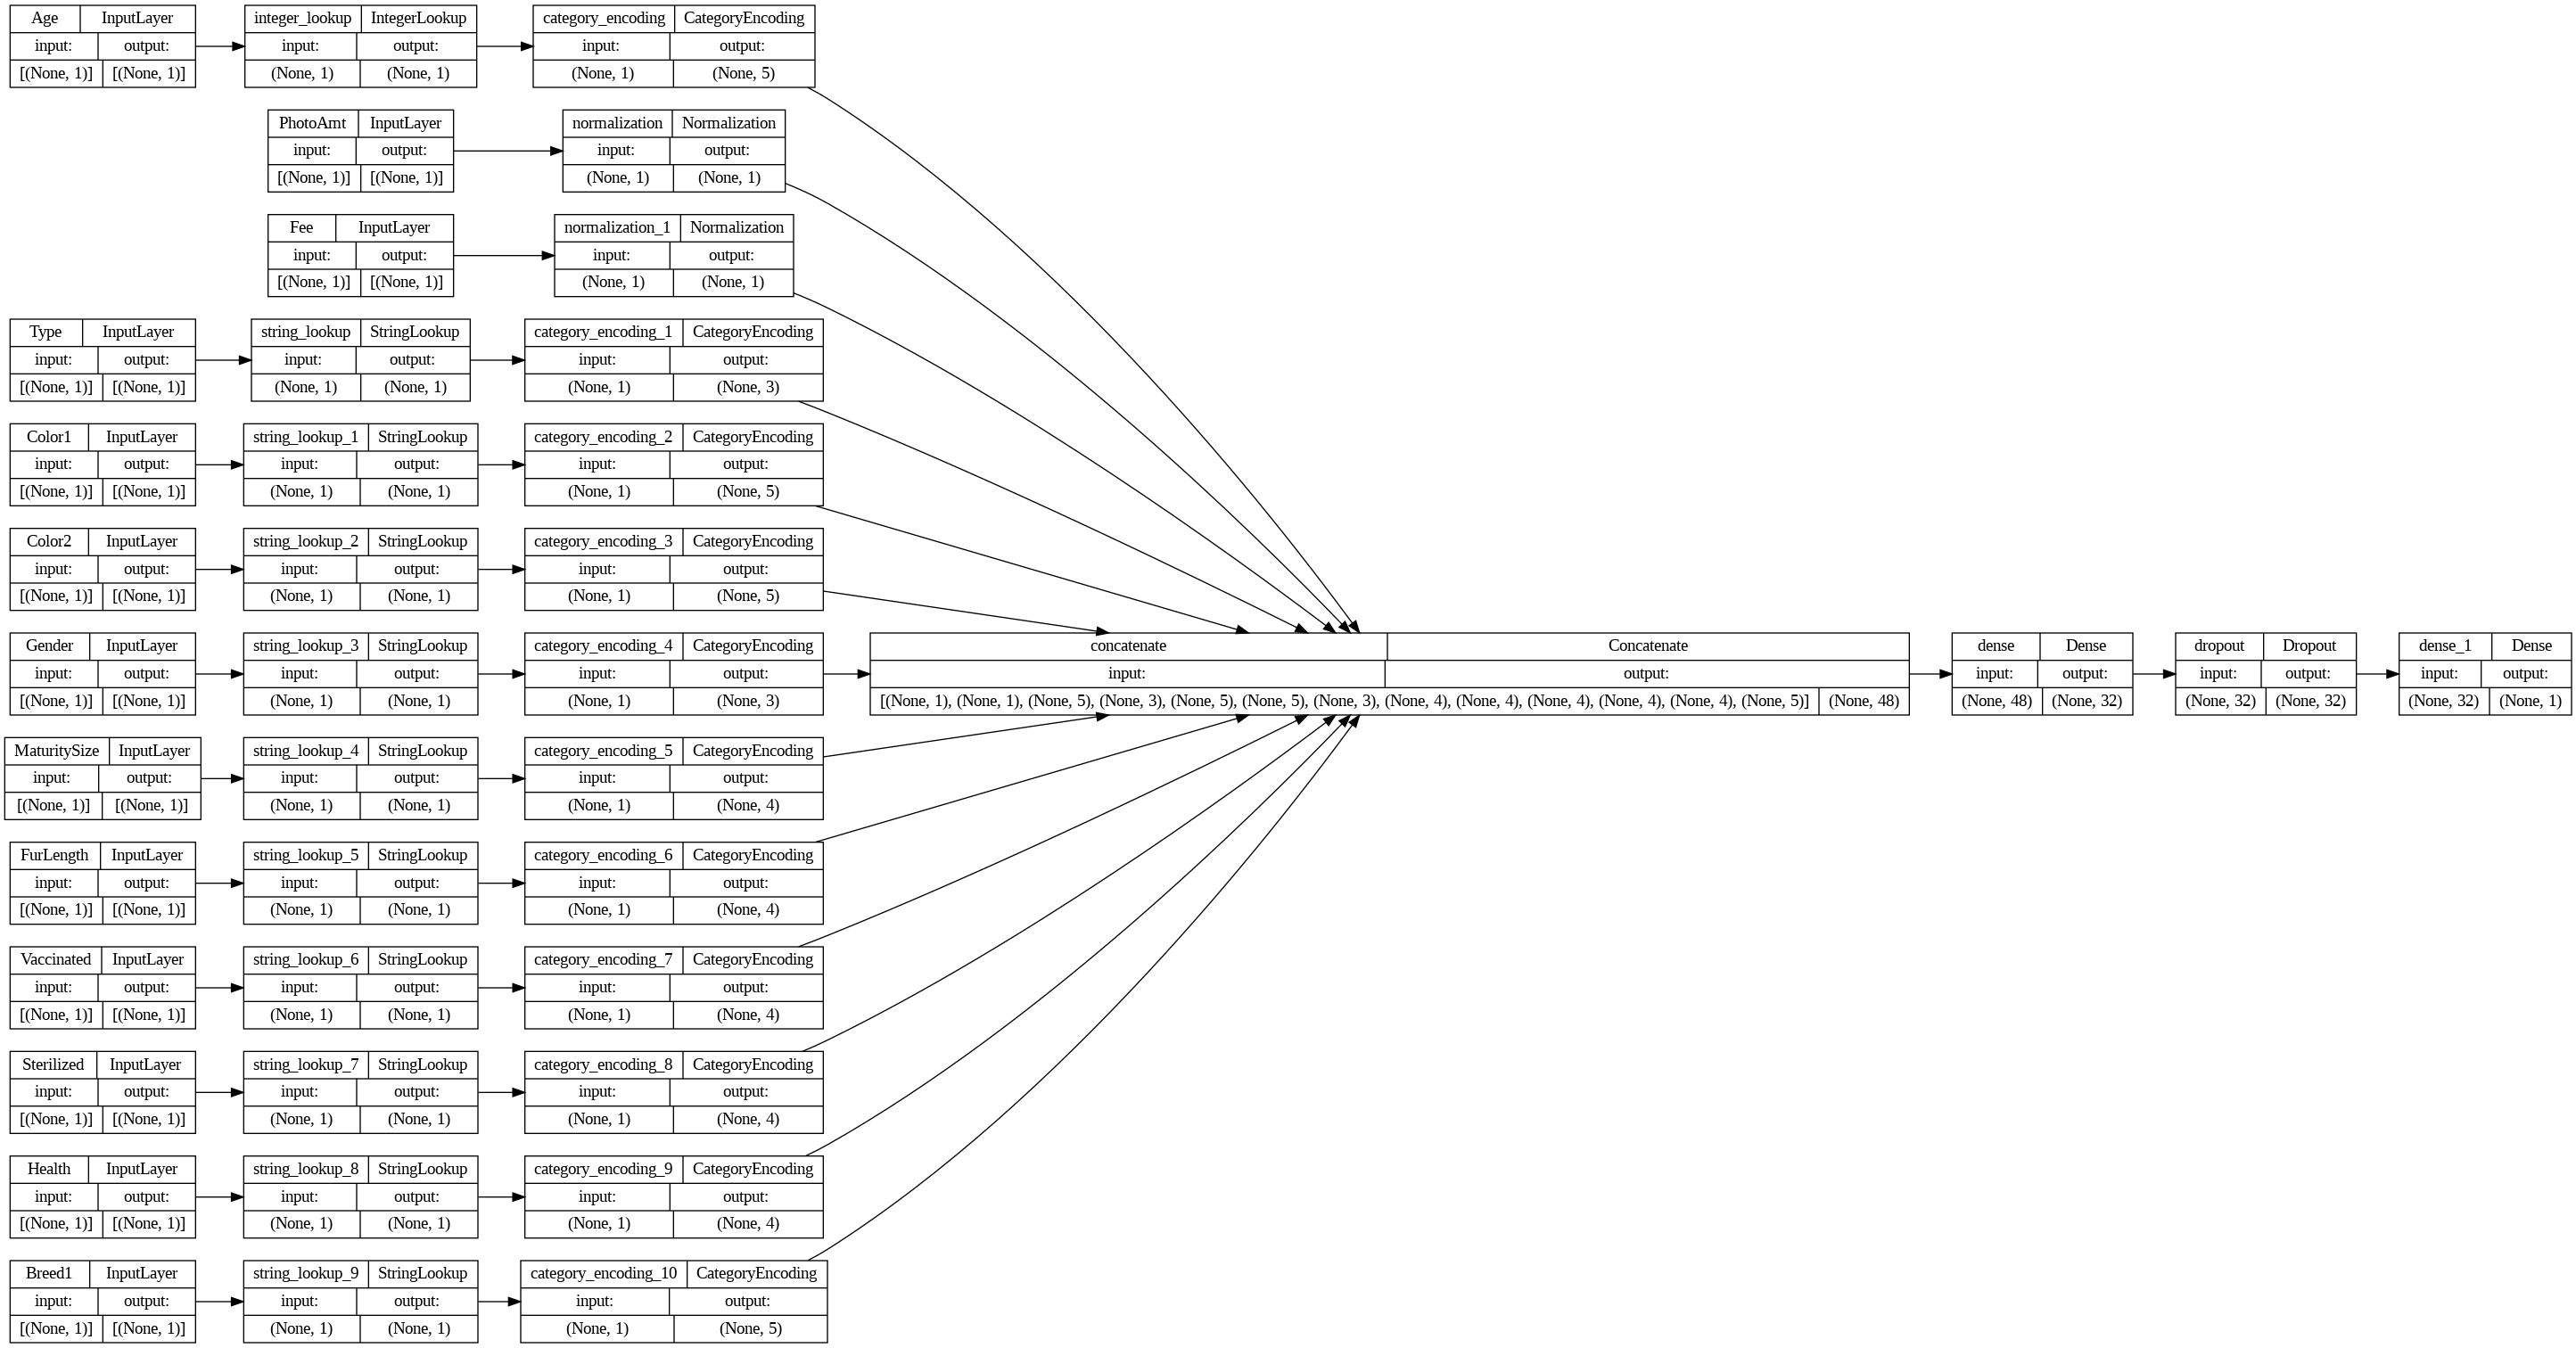

In [ ]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
baseline_history = model.fit(train_ds, epochs=10, validation_data=val_ds)
baseline_history

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


37/37 [==============================] - 2s 17ms/step - loss: 0.7261 - accuracy: 0.4855 - val_loss: 0.6117 - val_accuracy: 0.6794
Epoch 2/10
37/37 [==============================] - 0s 5ms/step - loss: 0.6256 - accuracy: 0.6202 - val_loss: 0.5712 - val_accuracy: 0.7028
Epoch 3/10
37/37 [==============================] - 0s 6ms/step - loss: 0.5892 - accuracy: 0.6400 - val_loss: 0.5474 - val_accuracy: 0.7218
Epoch 4/10
37/37 [==============================] - 0s 5ms/step - loss: 0.5684 - accuracy: 0.6722 - val_loss: 0.5320 - val_accuracy: 0.7374
Epoch 5/10
37/37 [==============================] - 0s 5ms/step - loss: 0.5581 - accuracy: 0.6861 - val_loss: 0.5223 - val_accuracy: 0.7426
Epoch 6/10
37/37 [==============================] - 0s 5ms/step - loss: 0.5514 - accuracy: 0.6936 - val_loss: 0.5166 - val_accuracy: 0.7565
Epoch 7/10
37/37 [==============================] - 0s 5ms/step - loss: 0.5436 - accuracy: 0.7037 - val_loss: 0.5110 - val_accuracy: 0.7617
Epoch 8/10
37/37 [============

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", np.round(accuracy, 3))

5/5 [==============================] - 0s 5ms/step - loss: 0.5257 - accuracy: 0.7175
Accuracy 0.718


In [ ]:
test['target'].values

array([0, 1, 1, ..., 0, 1, 0])

In [ ]:
model.predict(test_ds).flatten()

5/5 [==============================] - 0s 5ms/step


array([0.11473144, 1.9194527 , 2.0470948 , ..., 0.6485135 , 0.44487685,
       0.34633797], dtype=float32)

5/5 [==============================] - 0s 4ms/step


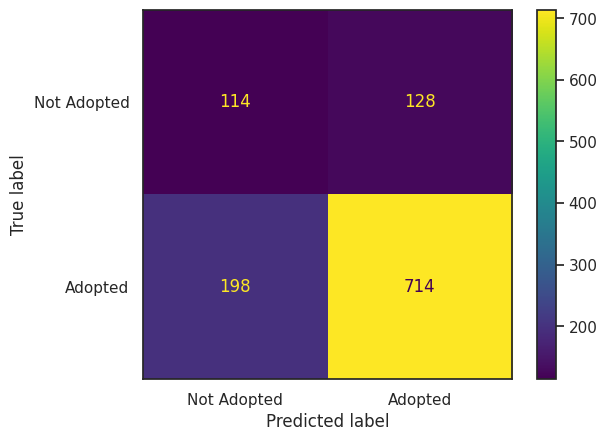

In [ ]:
cm = confusion_matrix((model.predict(test_ds) > 0.5).astype("int32").flatten(), test['target'].values)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Adopted','Adopted'])
disp.plot()

In [ ]:
precision = precision_score((model.predict(test_ds) > 0.5).astype("int32").flatten(), test['target'].values)
recall    = recall_score((model.predict(test_ds) > 0.5).astype("int32").flatten(), test['target'].values)
print(classification_report((model.predict(test_ds) > 0.5).astype("int32").flatten(), test['target'].values, target_names=['Not Adopted','Adopted']))

5/5 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

 Not Adopted       0.37      0.47      0.41       242
     Adopted       0.85      0.78      0.81       912

    accuracy                           0.72      1154
   macro avg       0.61      0.63      0.61      1154
weighted avg       0.75      0.72      0.73      1154



In [ ]:
model.save('my_pet_classifier')
reloaded_model = tf.keras.models.load_model('my_pet_classifier')

In [ ]:
sample = {
    'Type': 'Dog',
    'Age': 1,
    'Breed1': 'Tabby',
    'Gender': 'Female',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 10,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

1/1 [==============================] - 0s 415ms/step
This particular pet had a 87.5 percent probability of getting adopted.


In [ ]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

1/1 [==============================] - 0s 34ms/step
This particular pet had a 70.0 percent probability of getting adopted.


In [ ]:
sample = {
    'Type': 'Dog',
    'Age': 10,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

1/1 [==============================] - 0s 32ms/step
This particular pet had a 63.0 percent probability of getting adopted.


#Compare

In [ ]:
pd.DataFrame([[test_accuracy_sm, test_precision_sm, test_recall_sm],
              [test_accuracy_sk, test_precision_sk, test_recall_sk],
              [accuracy, precision, recall]],
             index=['statsmodels', 'scikit-learn', 'tensorflow'],
             columns=['Accuracy', 'Precision', 'Recall']).round(2)

,Accuracy,Precision,Recall
statsmodels,0.73,0.73,1.00
scikit-learn,0.73,0.73,1.00
tensorflow,0.72,0.85,0.78
